# Import necessary libraries

In [195]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Common libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import copy

In [3]:
# Scikit-learn
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import sklearn.metrics as metrics

In [4]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
!pip install abroca
!pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
from abroca import compute_abroca
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

In [5]:
# SciPy
from scipy import interpolate, integrate

# Evaluation metrics

## Fbeta score

In [68]:
def precision_score(y_true, y_pred):
  _, fp, _, tp = confusion_matrix(y_true, y_pred).ravel()

  precision = tp / (tp + fp) if tp + fp else 1
  precision = tp / (tp + fp + 1e-8)

  return precision

def recall_score(y_true, y_pred):
  _, _, fn, tp = confusion_matrix(y_true, y_pred).ravel()

  recall = tp / (tp + fn)

  return recall

def fbeta_score(y_true, y_prob, threshold=0.5, beta=1):
  Precision = precision_score(y_true=y_true, y_pred=(y_prob >= threshold))
  Recall = recall_score(y_true=y_true, y_pred=(y_prob >= threshold))

  fbeta = ((1 + beta ** 2) * Precision * Recall) / (beta ** 2 * Precision + Recall)

  return fbeta


## Accuracy

In [69]:
def accuracy_score(y_true, y_prob, type_eval="prob", threshold=0.5):
  y_pred = (y_prob >= threshold) if type_eval == "prob" else y_prob

  correct_samples = np.sum(y_true == y_pred)
  total_samples = y_true.shape[0]

  return (correct_samples / total_samples)

## Area under ROC curve (AUC-ROC)

In [70]:
def interpolate_roc_fun(fpr, tpr, n_grid):
  """
  Function to Use interpolation to make approximate the Receiver Operating Characteristic (ROC) curve along n_grid equally-spaced values.
  fpr - vector of false positive rates computed from compute_roc
  tpr - vector of true positive rates computed from compute_roc
  n_grid - number of approximation points to use (default value of 10000 more than adequate for most applications) (numeric)

  Returns  a list with components x and y, containing n coordinates which  interpolate the given data points according to the method (and rule) desired
  """
  roc_approx = interpolate.interp1d(x=fpr, y=tpr)
  x_new = np.linspace(0, 1, num=n_grid)
  y_new = roc_approx(x_new)
  return x_new, y_new

def compute_roc(y_true, y_prob, step):
    TPR_list = []
    FPR_list = []
    for threshold in np.arange(0, 1+step, step):
      y_pred = (y_prob >= threshold)
      TPR = TPR_score(y_true, y_pred)
      FPR = 1 - TNR_score(y_true, y_pred)

      TPR_list.append(TPR)
      FPR_list.append(FPR)

    return np.array(FPR_list), np.array(TPR_list)

In [71]:
def to_TFNP(y_test, y_pred):
  y_ground_truth_np = y_test
  y_prediction_np = y_pred

  #print(y_ground_truth_np.shape, y_prediction_np.shape)

  TN, FP, FN, TP = confusion_matrix(y_ground_truth_np, y_prediction_np).ravel()

  #print(confusion_matrix(y_ground_truth_np, y_prediction_np))

  #print(confusion_matrix(y_ground_truth_np, y_prediction_np))

  #print(f"true positives: {TP}")
  #print(f"false positives: {FP}")
  #print(f"true negatives: {TN}")
  #print(f"false negatives: {FN}")

  return TN, FP, FN, TP

# sensitivity score
def TPR_score(y_true, y_pred):
  _, _, FN, TP = to_TFNP(y_true, y_pred)
  TPR = TP / (TP + FN)

  return TPR

# specificity score
def TNR_score(y_true, y_pred):
  TN, FP, _, _ = to_TFNP(y_true, y_pred)
  TNR = TN / (FP + TN)

  return TNR



In [72]:
def calculate_auc_roc_score(TPR, FPR, n_grid=10000):
  roc_x, roc_y = interpolate_roc_fun(
      fpr=FPR,
      tpr=TPR,
      n_grid=n_grid
  )
  f1 = interpolate.interp1d(x=roc_x, y=roc_y)
  f2 = lambda x, acc: abs(f1(x))
  slices, _ = integrate.quad(f2, 0, 1, 50)

  #print(auc)
  #print(np.trapz(TPR, FPR))

  #print(f"FPR: {FPR}")
  #print(f"TPR: {TPR}")

  return slices

def auc_roc_score(y_true, y_prob, step=0.01):
  TPR_list = []
  FPR_list = []
  for threshold in np.arange(0, 1+step, step):
    y_pred = (y_prob >= threshold)
    TPR = TPR_score(y_true, y_pred)
    FPR = 1 - TNR_score(y_true, y_pred)

    TPR_list.append(TPR)
    FPR_list.append(FPR)

  plt.plot(FPR_list, TPR_list)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC curve")
  plt.show()

  return calculate_auc_roc_score(TPR_list, FPR_list)

In [73]:
#roc_auc_score(y_true=df["decision"], y_score=df["probability"])

## Area under PR curve (AUC-PR)

In [74]:
def auc_pr_score(y_true, y_pred):
  precision, recall, thresholds = precision_recall_curve(y_true=df["decision"], probas_pred=df["probability"])

  plt.plot(recall, precision)
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Precision-recall curve")
  plt.show()

  f1 = interpolate.interp1d(x=recall, y=precision)
  f2 = lambda x, acc: abs(f1(x))
  slices, _ = integrate.quad(f2, 0, 1, 50)

  return slices

## Demographic Parity

In [95]:
def demographic_parity_plot(y_true, y_prob, sensitive_features, privileged_group, eval_type="binary", step=0.05, plotting=True, threshold_draw=0.5):
  data_comb = pd.concat([y_true, y_prob, sensitive_features], axis=1)
  column_mapping = dict(zip(data_comb.columns, ["Truth", "Probability", "Sensitive feature"]))
  data_comb = data_comb.rename(columns=column_mapping)

  thresholds = np.arange(0, 1+step, step)
  plt.axvline(threshold_draw, color='r', label="Threshold") # vertical

  positives_rate_list = []
  positive_rate_dict = {}

  if eval_type == "binary":

    # privileged group
    test_data = data_comb.loc[data_comb["Sensitive feature"] == privileged_group]
    positives_rate_list.clear()

    for threshold in thresholds:
      y_pred = test_data["Probability"] >= threshold
      positives_rate = np.sum(y_pred) / (y_pred.shape[0])
      positives_rate_list.append(positives_rate)

    positive_rate_dict[privileged_group] = copy.deepcopy(positives_rate_list)

    group_label = str(privileged_group) + " (privileged group)"
    plt.plot(thresholds, positives_rate_list, label=group_label)
    # unprivileged group(s)
    test_data = data_comb.loc[data_comb["Sensitive feature"] != privileged_group]
    positives_rate_list.clear()

    for threshold in thresholds:
      y_pred = test_data["Probability"] >= threshold
      positives_rate = np.sum(y_pred) / (y_pred.shape[0])
      positives_rate_list.append(positives_rate)

    positive_rate_dict["non-" + privileged_group] = copy.deepcopy(positives_rate_list)

    group_label = "Unprivileged group(s)"
    plt.plot(thresholds, positives_rate_list, label=group_label)

    plt.title(f"Binary positives label percentage plot")

  else:
    for group in data_comb["Sensitive feature"].unique():
      positives_rate_list.clear()
      test_data = data_comb.loc[data_comb["Sensitive feature"] == group]

      for threshold in thresholds:
        y_pred = test_data["Probability"] >= threshold
        positives_rate = np.sum(y_pred) / (y_pred.shape[0])
        positives_rate_list.append(positives_rate)

      group_label = str(group)
      if group == privileged_group:
        group_label += " (privileged group)"
      plt.plot(thresholds, positives_rate_list, label=group_label)

      positive_rate_dict[group] = copy.deepcopy(positives_rate_list)

    plt.title(f"All-group positives label percentage plot")

  plt.xlabel("Threshold")
  plt.ylabel("Positive labels percentage")
  plt.legend()
  plt.show()

  return positive_rate_dict

In [76]:
def demographic_parity_score(y_true, y_prob, sensitive_features, privileged_group, eval_type="binary", step=0.05, threshold=0.5, plotting=True):
  positive_rate_dict = demographic_parity_plot(y_true, y_prob, sensitive_features, privileged_group, eval_type, step, plotting, threshold_draw=threshold)

  multiple = threshold / step
  privileged_plr = 0
  positive_label_rate = []

  if multiple == float(int(multiple)):
    multiple = int(multiple)
    for key, item in positive_rate_dict.items():
      pl_rate = item[multiple]
      if key == privileged_group:
        privileged_plr = pl_rate
      else:
        positive_label_rate.append(pl_rate)
  else:
    theta = np.ceil(multiple) - multiple
    floor_num = int(multiple)
    for key, item in positive_rate_dict.items():
      #print(item)
      pl_rate = theta * item[floor_num] + (1 - theta) * item[floor_num + 1]
      if key == privileged_group:
        privileged_plr = pl_rate
      else:
        positive_label_rate.append(pl_rate)

      #print(f"Group: {key}, Rate: {pl_rate}")

  max_diff = 0
  for i in range(len(positive_label_rate)):
    diff_rate = abs(privileged_plr - positive_label_rate[i])
    #print(privileged_plr, positive_label_rate[i])
    max_diff = max(max_diff, diff_rate)

  return max_diff


## Predictive Parity

In [77]:
def NPV_score(y_true, y_pred):
  tn, _, fn, _ = confusion_matrix(y_true, y_pred).ravel()

  npv = tn / (tn + fn) if tn + fn else 1
  npv = tn / (tn + fn + 1e-8)

  return npv

In [78]:
def predictive_parity_sole(y_true, y_prob, step=0.05):
  NPV_list = []
  precision_list = []

  min_threshold, max_threshold = y_prob.min(), y_prob.max()

  thresholds = []

  for t in np.arange(0, 1+step, step):
    if t < min_threshold or t > max_threshold:
      continue

    thresholds.append(t)

    NPV = NPV_score(y_true=y_true, y_pred=(y_prob >= t))
    precision = precision_score(y_true=y_true, y_pred=(y_prob >= t))

  fNPV = interpolate.interp1d(x=thresholds, y=NPV_list)
  fprecision = interpolate.interp1d(x=thresholds, y=NPV_list)
  min_t = thresholds[0]
  max_t = thresholds[-1]

  return fNPV, fprecision, min_t, max_t

def predictive_parity_score(y_true, y_prob, sensitive_features, privileged_group, threshold=0.5, step=0.05):
  data_comb = pd.concat([y_true, y_prob, sensitive_features], axis=1)
  column_mapping = dict(zip(data_comb.columns, ["Truth", "Probability", "Sensitive feature"]))
  data_comb = data_comb.rename(columns=column_mapping)

  NPV_dict, precision_dict = {}, {}
  NPV_dict["all"], precision_dict["all"], min_t, max_t = predictive_parity_sole(y_true=data_comb["Truth"], y_prob=data_comb["Probability"], step=step)

  for group in data_comb["Sensitive feature"].unique():
    test_data = data_comb.loc[data_comb["Sensitive feature"] == group]
    NPV_dict[group], precision_dict[group], min_t_cur, max_t_cur = predictive_parity_sole(y_true=test_data["Truth"], y_prob=test_data["Probability"], step=step)
    min_t = max(min_t, min_t_cur)
    max_t = min(max_t, max_t_cur)

  plt.plot(thresholds, NPV_list, label="NPV")
  plt.plot(thresholds, precision_list, label="Precision")
  plt.title("NPV and precision based on threshold")
  plt.xlabel("Threshold")
  plt.legend()
  plt.show()

  fNPV = interpolate.interp1d(x=thresholds, y=NPV_list)
  print(fNPV(threshold))


In [79]:
#predictive_parity_score(y_true=df["decision"], y_prob=df["probability"], sensitive_features=df["gender"], privileged_group="male")

## ABROCA + Equalized Odds

In [80]:
def slice_plot(
    fpr_tpr_dict,
    privileged_group,
    plot_x_pts,
    plot_y_pts,
    threshold
):
    """
    Function to create a 'slice plot' of two roc curves with area between them (the ABROCA region) shaded.

    majority_roc_fpr, minority_roc_fpr - FPR of majority and minority groups
    majority_roc_tpr, minority_roc_tpr - TPR of majority and minority groups
    majority_group_name - (optional) - majority group display name on the slice plot
    minority_group_name - (optional) - minority group display name on the slice plot
    fout - (optional) -  File name (including directory) to save the slice plot generated

    No return value; displays slice plot & file is saved to disk
    """
    plt.figure(1, figsize=(6, 5))
    plt.title(f"ABROCA - Slice Plot with threshold {threshold}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    for key, item in fpr_tpr_dict.items():
      o2 = " - Baseline" if key == privileged_group else ""
      plt.plot(
          item[0],
          item[1],
          label="{o}{o2}".format(o=key, o2=o2),
          linestyle="-",
      )

    plt.scatter(plot_x_pts, plot_y_pts, color="r")
    """
    plt.fill(
        majority_roc_fpr.tolist() + np.flipud(minority_roc_fpr).tolist(),
        majority_roc_tpr.tolist() + np.flipud(minority_roc_tpr).tolist(),
        "y",
    )"""
    plt.legend()
    plt.show()

In [81]:
def eq_odds_score(fpr_tpr_dict, privileged_group, threshold, n_grid):

  multiple = threshold * n_grid
  print(f"Multiple: {multiple}")
  max_eq_odds = 0
  pg_fpr = fpr_tpr_dict[privileged_group][0]
  pg_tpr = fpr_tpr_dict[privileged_group][1]
  plot_x_pts = []
  plot_y_pts = []
  if multiple == float(int(multiple)):
    pg_fpr_pt = pg_fpr[int(multiple)]
    pg_tpr_pt = pg_tpr[int(multiple)]
    plot_x_pts.append(pg_fpr_pt)
    plot_y_pts.append(pg_tpr_pt)

    print(f"FPR all values group {privileged_group} = {pg_fpr}, len={pg_fpr.shape}")
    print(f"TPR all values group {privileged_group} = {pg_tpr}, len={pg_tpr.shape}")
    print(f"FPR group {privileged_group} = {pg_fpr_pt}")
    print(f"TPR group {privileged_group} = {pg_fpr_pt}")

    for key, item in fpr_tpr_dict.items():
      if key == privileged_group:
        continue

      upg_fpr_pt = item[0][int(multiple)]
      upg_tpr_pt = item[1][int(multiple)]
      eq_odds = abs(pg_fpr_pt - upg_fpr_pt) + abs(pg_tpr_pt - upg_tpr_pt)
      max_eq_odds = max(eq_odds, max_eq_odds)

      plot_x_pts.append(upg_fpr_pt)
      plot_y_pts.append(upg_tpr_pt)

      print(f"FPR group {key} = {upg_fpr_pt}")
      print(f"TPR group {key} = {upg_tpr_pt}")

      print(f"Equalized odds between {privileged_group} and {key} at threshold {threshold} is: {eq_odds} ")
  else:
    theta = np.ceil(multiple) - multiple
    flr = int(multiple)
    pg_fpr_pt = theta * pg_fpr[flr] + (1 - theta) * pg_fpr[flr + 1]
    pg_tpr_pt = theta * pg_tpr[flr] + (1 - theta) * pg_tpr[flr + 1]
    plot_x_pts.append(pg_fpr_pt)
    plot_y_pts.append(pg_tpr_pt)

    for key, item in fpr_tpr_dict.items():
      if key == privileged_group:
        continue

      upg_fpr_pt = theta * item[0][flr] + (1 - theta) * item[0][flr + 1]
      upg_tpr_pt = theta * item[1][flr] + (1 - theta) * item[1][flr + 1]
      eq_odds = abs(pg_fpr_pt - upg_fpr_pt) + abs(pg_tpr_pt - upg_tpr_pt)
      max_eq_odds = max(eq_odds, max_eq_odds)

      plot_x_pts.append(upg_fpr_pt)
      plot_y_pts.append(upg_tpr_pt)

      print(f"Equalized odds between {privileged_group} and {key} at threshold {threshold} is: {eq_odds} ")

  return max_eq_odds, plot_x_pts, plot_y_pts

In [82]:
def compute_abroca_score(y_true, y_prob, sensitive_features, privileged_group, step=0.05, threshold=0.5, n_grid=10000):
    # combine data
    data_comb = pd.concat([y_true, y_prob, sensitive_features], axis=1)
    column_mapping = dict(zip(data_comb.columns, ["Truth", "Probability", "Sensitive feature"]))
    data_comb = data_comb.rename(columns=column_mapping)

    prot_attr_values = data_comb["Sensitive feature"].unique()
    fpr_tpr_dict = {}

    # compute roc within each group of pa_values
    """
    tmp_all = compute_roc(y_true=data_comb["Truth"], y_prob=data_comb["Probability"], step=step)
    roc_x_all, roc_y_all = interpolate_roc_fun(
            fpr=tmp_all[0],
            tpr=tmp_all[1],
            n_grid=10000,
    )
    fpr_tpr_dict["all"] = [roc_x_all, roc_y_all]
    """
    plot_x_pts = []
    plot_y_pts = []

    cur_FPR_list = {}
    cur_TPR_list = {}

    for pa_value in prot_attr_values:
        pa_df = data_comb[data_comb["Sensitive feature"] == pa_value]
        tmp = compute_roc(y_true=pa_df["Truth"], y_prob=pa_df["Probability"], step=step)

        fFPR = interpolate.interp1d(x=np.arange(0, 1+step, step), y=tmp[0])
        fTPR = interpolate.interp1d(x=np.arange(0, 1+step, step), y=tmp[1])
        plot_x_pts.append(fFPR(threshold))
        plot_y_pts.append(fTPR(threshold))

        #### Calculate TPR FPR by hand

        cur_FPR = 1 - TNR_score(y_true=pa_df["Truth"], y_pred=(pa_df["Probability"] >= threshold))
        cur_TPR = TPR_score(y_true=pa_df["Truth"], y_pred=(pa_df["Probability"] >= threshold))

        #y_predd = (pa_df["Probability"] >= threshold).value_counts()
        #print(f"Group {pa_value} with prediction {y_predd}")

        cur_FPR_list[pa_value] = cur_FPR
        cur_TPR_list[pa_value] = cur_TPR

        #print(cur_FPR, cur_TPR)

        #### End

        roc_x, roc_y = interpolate_roc_fun(
            fpr=tmp[0],
            tpr=tmp[1],
            n_grid=n_grid
        )
        fpr_tpr_dict[pa_value] = [roc_x, roc_y]

    score = 0

    for key, item in fpr_tpr_dict.items():
      if key == privileged_group:
        continue

      f1 = interpolate.interp1d(x=fpr_tpr_dict[privileged_group][0], y=(fpr_tpr_dict[privileged_group][1] - item[1]))
      f2 = lambda x, acc: abs(f1(x))
      slices, _ = integrate.quad(f2, 0, 1, 50)
      print(f"ABROCA score between {privileged_group} and {key}: {slices}")
      score = max(score, slices)

    #max_eq_odds, _, _ = eq_odds_score(fpr_tpr_dict, privileged_group, threshold, n_grid)

    #print(plot_x_pts)
    #print(plot_y_pts)

    slice_plot(fpr_tpr_dict, privileged_group, plot_x_pts, plot_y_pts, threshold)

    max_eq_odds = 0

    for key, item in cur_FPR_list.items():
      if key == privileged_group:
        continue

      eo_value = abs(cur_FPR_list[privileged_group] - item) + abs(cur_TPR_list[privileged_group] - cur_TPR_list[key])
      max_eq_odds = max(eo_value, max_eq_odds)
      #print(f"Hand-calculated equalized odds between {key} and {privileged_group} at threshold {threshold} is {eo_value}")

    #for key, item in cur_FPR_list.items():
      #print(f"At threshold {threshold}, FPR of {key} is {item} and TPR of {key} is {cur_TPR_list[key]}")

    #slices2 = compute_abroca(df=data_comb, label_col="Truth", pred_col="Probability", protected_attr_col="Sensitive feature", majority_protected_attr_val="Dutch", plot_slices=True)

    #print(f"From library: {slices2}")

    return score, max_eq_odds

<ipython-input-82-bbb88e536e21>:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


ABROCA score between male and female: 0.04282506164261081
ABROCA score between male and other: 0.1033621100967336


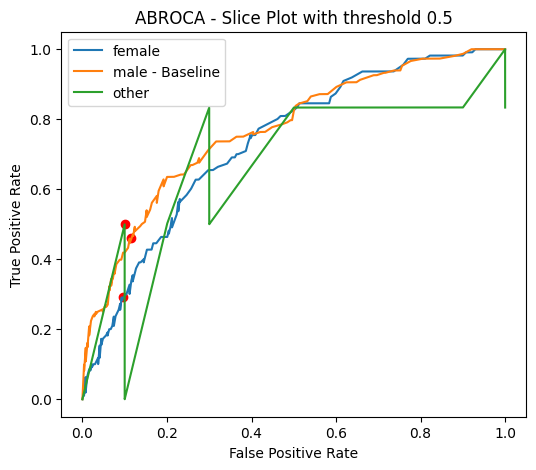

Maximum ABROCA score: 0.1033621100967336
Maximum equalized odd difference: 0.1878960934574318


In [83]:
max_abroca_score, max_eq_odds = compute_abroca_score(y_true=df["decision"], y_prob=df["probability"], sensitive_features=df["gender"], privileged_group="male", step=0.005)
print(f"Maximum ABROCA score: {max_abroca_score}")
print(f"Maximum equalized odd difference: {max_eq_odds}")

# Data Path

In [246]:
# Path to the data
data_folder = "/content/drive/MyDrive/ML - Bài tập nhóm/Datasets"

# List of datasets to evaluate
LR = "LR_output.csv"
LR_no_sensitive = "LR_output_no_sensitive.csv"

SVM = "SVM_output.csv"
SVM_no_sensitive = "SVM_output_no_sensitive.csv"

SVM_rbf = "SVM_rbf_output.csv"
SVM_rbf_no_sensitive = "SVM_rbf_output_no_sensitive.csv"

RF_prob_high = "RF_probability_low.csv"
RF_prob_low = "RF_probability_high.csv"
RF_no_sensitive = "RF_probability_no_sensitive.csv"

DT = "DT_probability.csv"
DT_no_sensitive = "DT_probability_no_sensitive.csv"

RF = "RF_probability.csv"
GB = "GB_probability.csv"
GB_no_sensitive = "GB_probability_no_sensitive.csv"

poly = "poly_output.csv"
poly_no_sensitive = "poly_no_sensitive_output.csv"

# Join path

# -------> Change name of dataset HERE <-------
data_path = os.path.join(data_folder, GB) # change on this line to evaluate
data_path_no_sensitive = os.path.join(data_folder, GB_no_sensitive) # change on this line to evaluate
data_path

'/content/drive/MyDrive/ML - Bài tập nhóm/Datasets/GB_probability.csv'

# Data Preparation

In [247]:
df = pd.read_csv(data_path).drop("Unnamed: 0", axis=1)
df_no_sensitive = pd.read_csv(data_path_no_sensitive).drop("Unnamed: 0", axis=1)
df.head()

,gender,age,nationality,sport,university_grade,debateclub_exp,international_exp,ind-entrepeneur_exp,languages,degree,company,decision,probability
0,female,24,Dutch,Rugby,64,False,True,True,2,master,A,True,0.695535
1,male,26,German,Swimming,67,False,False,False,1,master,A,True,0.606739
2,male,22,Belgian,Football,65,True,False,True,1,bachelor,C,False,0.167733
3,male,27,Dutch,Running,62,False,False,False,1,bachelor,B,False,0.082723
4,male,25,Dutch,Tennis,61,False,False,False,1,bachelor,A,False,0.238890


In [248]:
#full false
#df["probability"] = np.zeros(len(df))
df.head()

,gender,age,nationality,sport,university_grade,debateclub_exp,international_exp,ind-entrepeneur_exp,languages,degree,company,decision,probability
0,female,24,Dutch,Rugby,64,False,True,True,2,master,A,True,0.695535
1,male,26,German,Swimming,67,False,False,False,1,master,A,True,0.606739
2,male,22,Belgian,Football,65,True,False,True,1,bachelor,C,False,0.167733
3,male,27,Dutch,Running,62,False,False,False,1,bachelor,B,False,0.082723
4,male,25,Dutch,Tennis,61,False,False,False,1,bachelor,A,False,0.238890


In [249]:
over_29 = np.array((df["age"] >= 29).values, dtype=int)
over_24 = np.array((df["age"] >= 24).values, dtype=int)

age_group = np.add(over_29, over_24)

age_group_str = []

age_group_val = ["<= 23", "24-28", ">= 29"]

for i in range(len(age_group)):
  age_group_str.append(age_group_val[age_group[i]])

df_age_group = pd.DataFrame(age_group_str, columns=["age_group"], index=df.index)
df = pd.concat([df, df_age_group], axis=1)
df_no_sensitive = pd.concat([df_no_sensitive, df_age_group], axis=1)

df

,gender,age,nationality,sport,university_grade,debateclub_exp,international_exp,ind-entrepeneur_exp,languages,degree,company,decision,probability,age_group
0,female,24,Dutch,Rugby,64,False,True,True,2,master,A,True,0.695535,24-28
1,male,26,German,Swimming,67,False,False,False,1,master,A,True,0.606739,24-28
2,male,22,Belgian,Football,65,True,False,True,1,bachelor,C,False,0.167733,<= 23
3,male,27,Dutch,Running,62,False,False,False,1,bachelor,B,False,0.082723,24-28
4,male,25,Dutch,Tennis,61,False,False,False,1,bachelor,A,False,0.238890,24-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,female,29,Dutch,Football,60,True,False,True,3,bachelor,D,False,0.142779,>= 29
789,female,26,Dutch,Rugby,51,False,False,False,2,master,B,True,0.451345,24-28
790,male,22,Dutch,Swimming,67,False,False,False,1,bachelor,D,True,0.292801,<= 23
791,male,26,Dutch,Tennis,52,True,False,True,3,bachelor,B,True,0.481634,24-28


In [250]:
sensitive_features = ["gender", "nationality", "age_group"]
privileged_group = ["male", "German", "24-28"]

# Report

## With sensitive feature

In [259]:
max_acc, max_fbeta = 0, 0
for i in np.arange(0.3, 0.6, 0.01):
  fbeta = fbeta_score(y_true=df["decision"], y_prob=df["probability"], threshold=i, beta=1)
  max_fbeta = max(max_fbeta, fbeta)

  acc = accuracy_score(y_true=df["decision"], y_prob=df["probability"], threshold=i)
  max_acc = max(max_acc, acc)

  print(f"Threshold {i}: F1 = {fbeta}; Accuracy = {acc}")

print(f"Max accuracy: {max_acc} + Max F1: {max_fbeta}")

Threshold 0.3: F1 = 0.7085346215666902; Accuracy = 0.7717528373266078
Threshold 0.31: F1 = 0.7096774193433923; Accuracy = 0.7730138713745272
Threshold 0.32: F1 = 0.7034035656287942; Accuracy = 0.7692307692307693
Threshold 0.33: F1 = 0.6982055464812691; Accuracy = 0.7667087011349306
Threshold 0.34: F1 = 0.6993464052173308; Accuracy = 0.7679697351828499
Threshold 0.35000000000000003: F1 = 0.7004909983518741; Accuracy = 0.7692307692307693
Threshold 0.36000000000000004: F1 = 0.7099999999881668; Accuracy = 0.7805800756620429
Threshold 0.37000000000000005: F1 = 0.7164685908197544; Accuracy = 0.7894073139974779
Threshold 0.38000000000000006: F1 = 0.7083333333210359; Accuracy = 0.7881462799495587
Threshold 0.39000000000000007: F1 = 0.7027972027849161; Accuracy = 0.78562421185372
Threshold 0.4000000000000001: F1 = 0.722846441934029; Accuracy = 0.8133669609079445
Threshold 0.4100000000000001: F1 = 0.7067961164911302; Accuracy = 0.8095838587641866
Threshold 0.4200000000000001: F1 = 0.699218749986

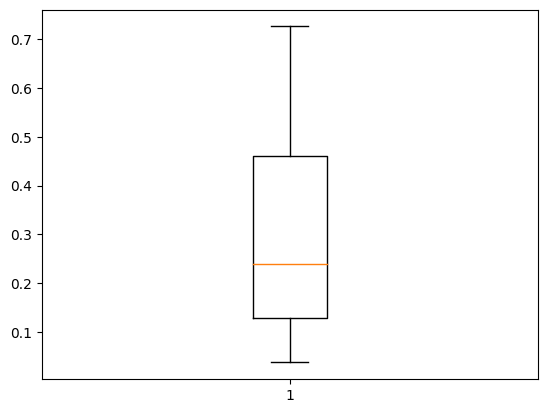

In [260]:
plt.boxplot(df["probability"])
plt.show()

Threshold = 0.3
Print value: False    436
True     357
Name: probability, dtype: int64
Print value: False    529
True     264
Name: decision, dtype: int64
F1 score: 0.7085346215666902
Accuracy: 0.7717528373266078


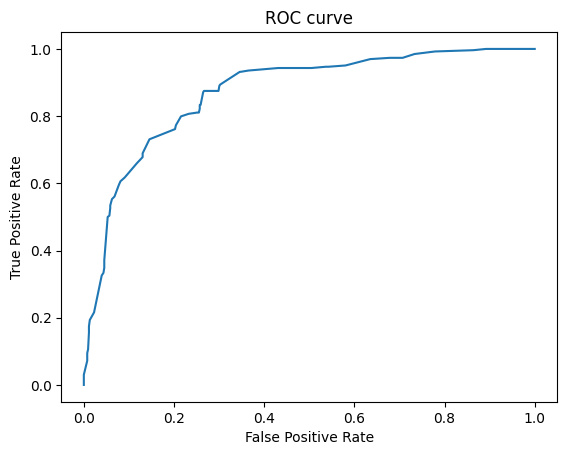

<ipython-input-72-1d3de18ab7ab>:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


AUC-ROC score: 0.8713890350988309


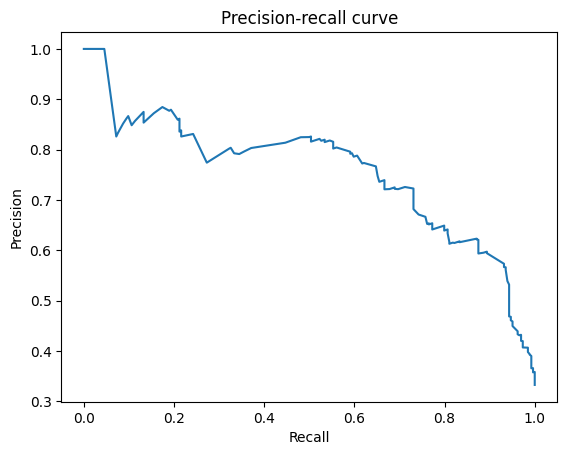

AUC-PR score: 0.7571331576419039


<ipython-input-74-3a86ea50269e>:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


In [261]:
threshold = 0.3
print(f"Threshold = {threshold}")
values = (df["probability"] >= threshold).value_counts()
print(f"Print value: {values}")

values = df["decision"].value_counts()
print(f"Print value: {values}")

fbeta = fbeta_score(y_true=df["decision"], y_prob=df["probability"], threshold=threshold, beta=1)
print(f"F1 score: {fbeta}")

accuracy = accuracy_score(y_true=df["decision"], y_prob=df["probability"], threshold=threshold)
print(f"Accuracy: {accuracy}")

auc_roc = auc_roc_score(y_true=df["decision"], y_prob=df["probability"])
print(f"AUC-ROC score: {auc_roc}")

auc_pr = auc_pr_score(y_true=df["decision"], y_pred=df["probability"])
print(f"AUC-PR score: {auc_pr}")

For feature gender:


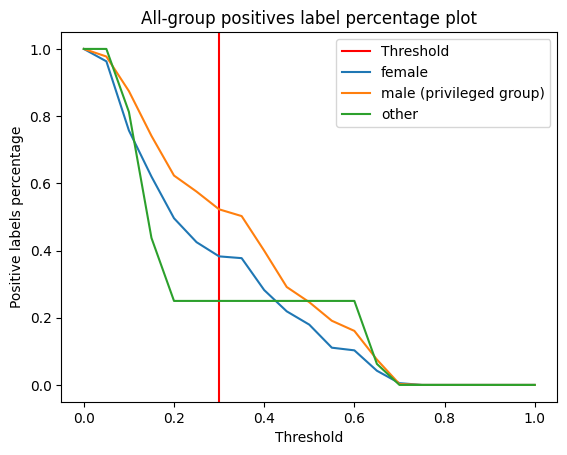

Demographic parity score: 0.2726130653266333


<ipython-input-82-bbb88e536e21>:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


ABROCA score between male and female: 0.02307618916968866
ABROCA score between male and other: 0.17404077450396316


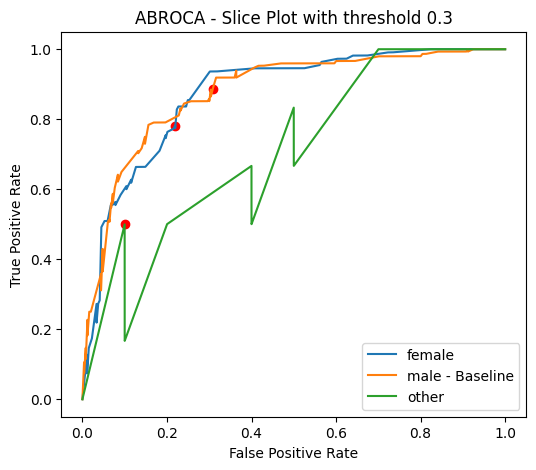

Maximum ABROCA score: 0.17404077450396316
Maximum equalized odd difference: 0.5931351351351352
For feature nationality:


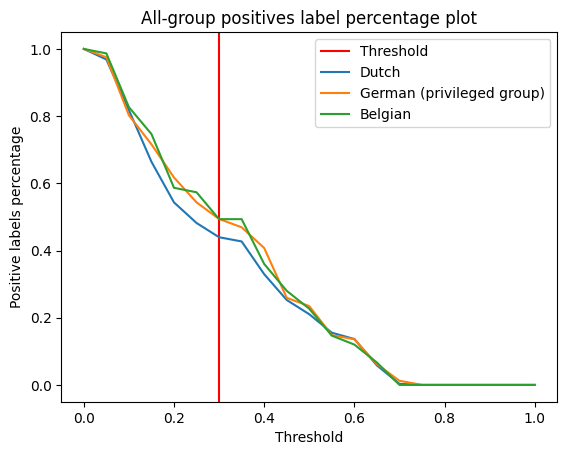

Demographic parity score: 0.05426672093338758


<ipython-input-82-bbb88e536e21>:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


ABROCA score between German and Dutch: 0.03632554653019493
ABROCA score between German and Belgian: 0.027162946190337312


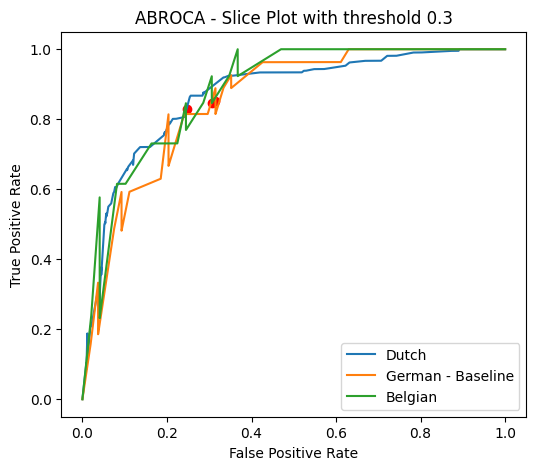

Maximum ABROCA score: 0.03632554653019493
Maximum equalized odd difference: 0.09080390717130582
For feature age_group:


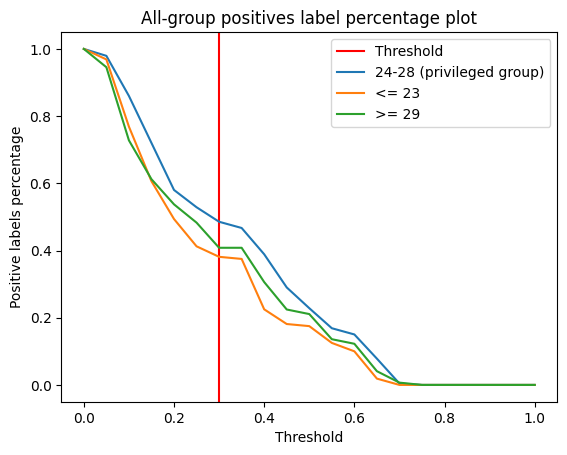

Demographic parity score: 0.10434670781893002


<ipython-input-82-bbb88e536e21>:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


ABROCA score between 24-28 and <= 23: 0.04320717924318998
ABROCA score between 24-28 and >= 29: 0.043956914514169367


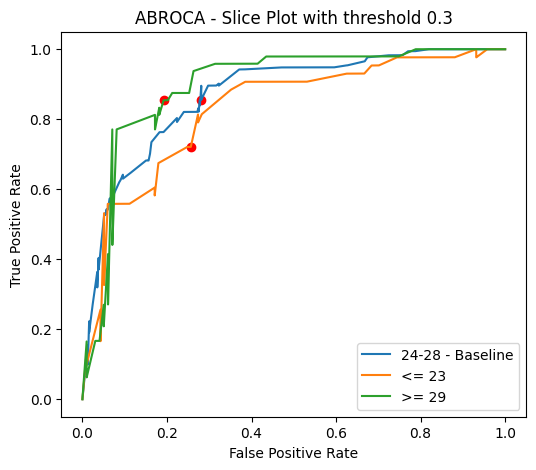

Maximum ABROCA score: 0.043956914514169367
Maximum equalized odd difference: 0.15930100025578187


In [262]:
for i in range(len(sensitive_features)):

  #print(df["nationality"].unique())

  print(f"For feature {sensitive_features[i]}:")
  demographic_parity = demographic_parity_score(y_true=df["decision"], y_prob=df["probability"], sensitive_features=df[sensitive_features[i]], privileged_group=privileged_group[i], eval_type="non-binary", step=0.05, threshold=threshold)
  print(f"Demographic parity score: {demographic_parity}")

  max_abroca_score, max_eq_odds = compute_abroca_score(y_true=df["decision"], y_prob=df["probability"], sensitive_features=df[sensitive_features[i]], privileged_group=privileged_group[i], step=0.005, threshold=threshold)
  print(f"Maximum ABROCA score: {max_abroca_score}")
  print(f"Maximum equalized odd difference: {max_eq_odds}")

## Without sensitive features

In [263]:
max_acc, max_fbeta = 0, 0
for i in np.arange(0.3, 0.6, 0.01):
  fbeta = fbeta_score(y_true=df_no_sensitive["decision"], y_prob=df_no_sensitive["probability"], threshold=i, beta=1)
  max_fbeta = max(max_fbeta, fbeta)

  acc = accuracy_score(y_true=df_no_sensitive["decision"], y_prob=df_no_sensitive["probability"], threshold=i)
  max_acc = max(max_acc, acc)

  print(f"Threshold {i}: F1 = {fbeta}; Accuracy = {acc}")

print(f"Max accuracy: {max_acc} + Max F1: {max_fbeta}")

Threshold 0.3: F1 = 0.8020134228053353; Accuracy = 0.8511979823455234
Threshold 0.31: F1 = 0.808149405758775; Accuracy = 0.8575031525851198
Threshold 0.32: F1 = 0.8123924268362755; Accuracy = 0.862547288776797
Threshold 0.33: F1 = 0.8153310104387572; Accuracy = 0.8663303909205549
Threshold 0.34: F1 = 0.8189806678239195; Accuracy = 0.8701134930643127
Threshold 0.35000000000000003: F1 = 0.8277087033600763; Accuracy = 0.8776796973518285
Threshold 0.36000000000000004: F1 = 0.8228980321856368; Accuracy = 0.8751576292559899
Threshold 0.37000000000000005: F1 = 0.8222621184771586; Accuracy = 0.8751576292559899
Threshold 0.38000000000000006: F1 = 0.8203266787509922; Accuracy = 0.8751576292559899
Threshold 0.39000000000000007: F1 = 0.8226691041897136; Accuracy = 0.8776796973518285
Threshold 0.4000000000000001: F1 = 0.8170055452714047; Accuracy = 0.8751576292559899
Threshold 0.4100000000000001: F1 = 0.8089887640297942; Accuracy = 0.8713745271122321
Threshold 0.4200000000000001: F1 = 0.80754716979

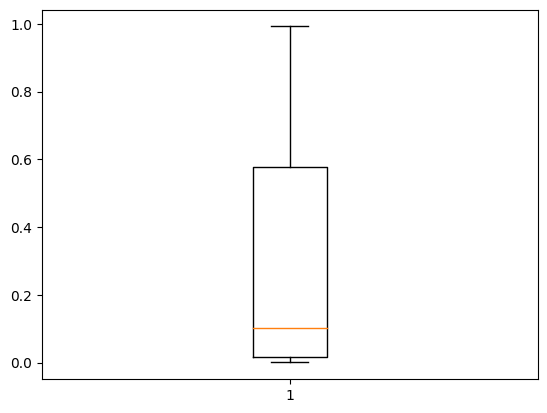

In [264]:
plt.boxplot(df_no_sensitive["probability"])
plt.show()

Threshold = 0.3
Print value: False    461
True     332
Name: probability, dtype: int64
Print value: False    529
True     264
Name: decision, dtype: int64
F1 score: 0.8020134228053353
Accuracy: 0.8511979823455234


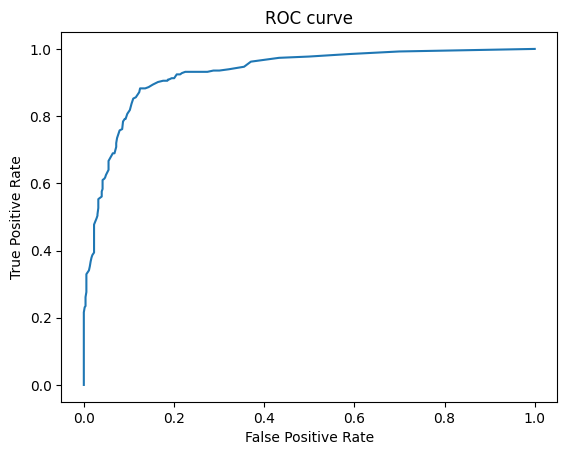

<ipython-input-72-1d3de18ab7ab>:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


AUC-ROC score: 0.9286582476078663


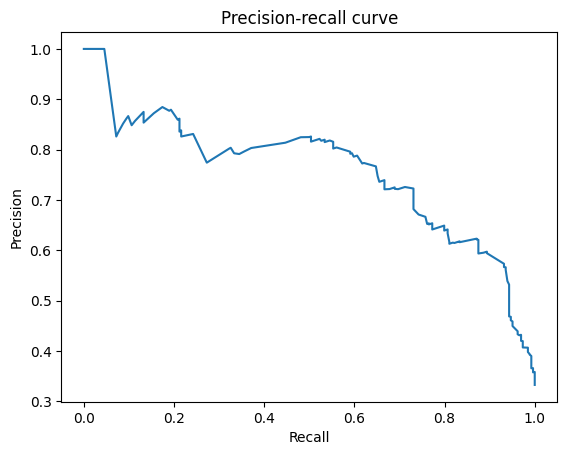

AUC-PR score: 0.7571331576419039


<ipython-input-74-3a86ea50269e>:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


In [265]:
threshold = 0.3
print(f"Threshold = {threshold}")
values = (df_no_sensitive["probability"] >= threshold).value_counts()
print(f"Print value: {values}")

values = df_no_sensitive["decision"].value_counts()
print(f"Print value: {values}")

fbeta = fbeta_score(y_true=df_no_sensitive["decision"], y_prob=df_no_sensitive["probability"], threshold=threshold, beta=1)
print(f"F1 score: {fbeta}")

accuracy = accuracy_score(y_true=df_no_sensitive["decision"], y_prob=df_no_sensitive["probability"], threshold=threshold)
print(f"Accuracy: {accuracy}")

auc_roc = auc_roc_score(y_true=df_no_sensitive["decision"], y_prob=df_no_sensitive["probability"])
print(f"AUC-ROC score: {auc_roc}")

auc_pr = auc_pr_score(y_true=df_no_sensitive["decision"], y_pred=df_no_sensitive["probability"])
print(f"AUC-PR score: {auc_pr}")

For feature gender:


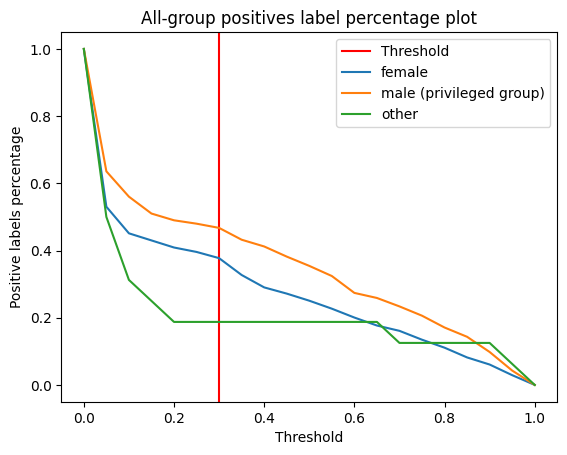

Demographic parity score: 0.2798366834170855


<ipython-input-82-bbb88e536e21>:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


ABROCA score between male and female: 0.014783972903439923
ABROCA score between male and other: 0.20152259388605132


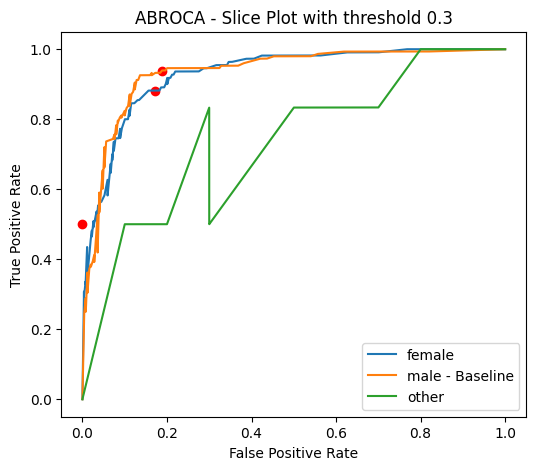

Maximum ABROCA score: 0.20152259388605132
Maximum equalized odd difference: 0.6271891891891891
For feature nationality:


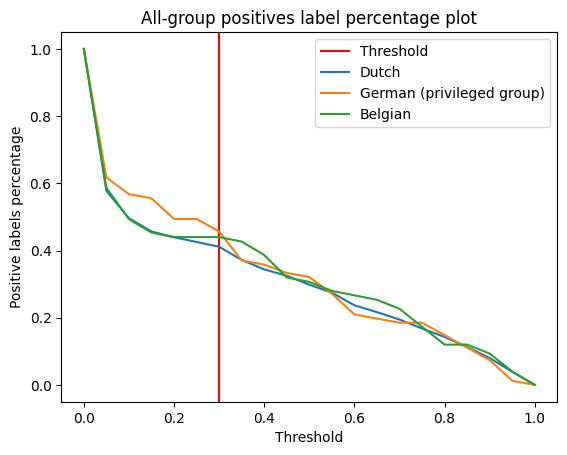

Demographic parity score: 0.04548714072523602


<ipython-input-82-bbb88e536e21>:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


ABROCA score between German and Dutch: 0.02606697616687032
ABROCA score between German and Belgian: 0.02043558935600897


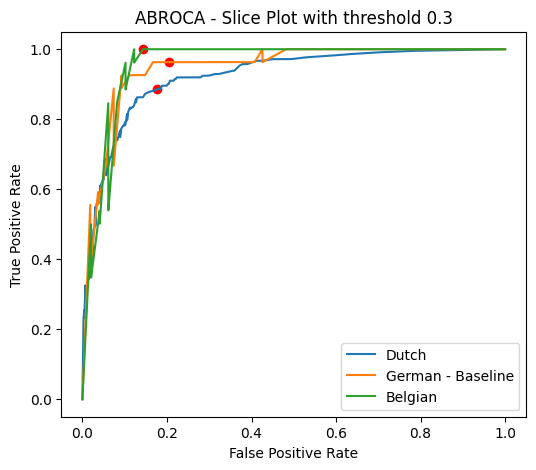

Maximum ABROCA score: 0.02606697616687032
Maximum equalized odd difference: 0.10435440446788147
For feature age_group:


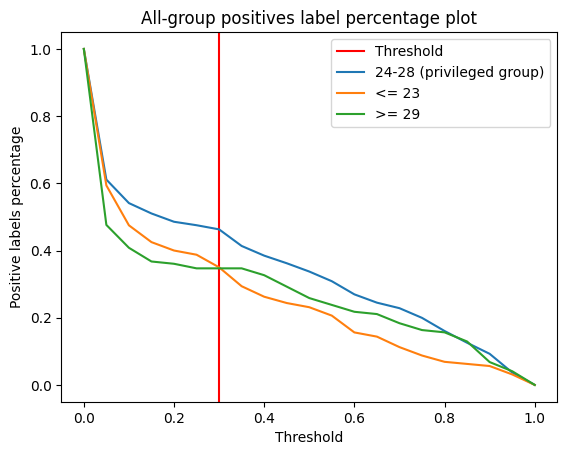

Demographic parity score: 0.11602418745275894


<ipython-input-82-bbb88e536e21>:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  slices, _ = integrate.quad(f2, 0, 1, 50)


ABROCA score between 24-28 and <= 23: 0.05934819770465524
ABROCA score between 24-28 and >= 29: 0.03162811382066544


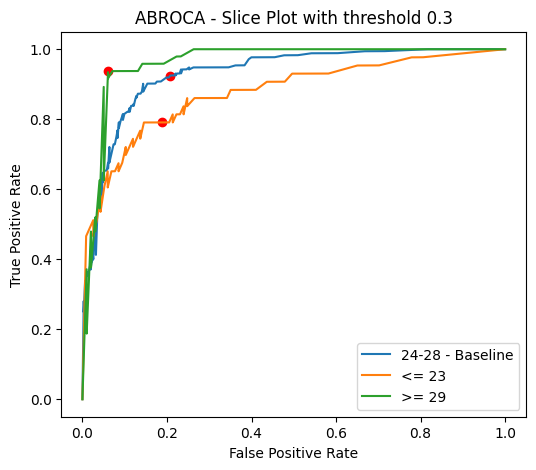

Maximum ABROCA score: 0.05934819770465524
Maximum equalized odd difference: 0.1597061796938527


In [266]:
for i in range(len(sensitive_features)):

  #print(df["nationality"].unique())

  print(f"For feature {sensitive_features[i]}:")
  demographic_parity = demographic_parity_score(y_true=df_no_sensitive["decision"], y_prob=df_no_sensitive["probability"], sensitive_features=df_no_sensitive[sensitive_features[i]], privileged_group=privileged_group[i], eval_type="non-binary", step=0.05, threshold=threshold)
  print(f"Demographic parity score: {demographic_parity}")

  max_abroca_score, max_eq_odds = compute_abroca_score(y_true=df_no_sensitive["decision"], y_prob=df_no_sensitive["probability"], sensitive_features=df_no_sensitive[sensitive_features[i]], privileged_group=privileged_group[i], step=0.005, threshold=threshold)
  print(f"Maximum ABROCA score: {max_abroca_score}")
  print(f"Maximum equalized odd difference: {max_eq_odds}")